In [1]:
import requests,json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
def get_prices(name):
    with open(name, 'rb') as f:
        pp = sorted(pickle.load(f), key=lambda x:x.id)
    closed_priced = [x.close for x in pp]
    df = pd.DataFrame([vars(f) for f in pp])
    df.dropna(inplace=True)
    print(df.tail())
    df['Timestamp'] = pd.to_datetime(df['id'], unit='s')
    df = df.set_index(df['Timestamp'])
    df = df.drop(columns=['id'])
    return df

In [3]:
df = get_prices('btc3lusdt_2021_03_30_00_54_10.pkl')
df.head()

                id      high       low      open     close     amount  count  \
126173  1617036240  358.9324  357.5266  357.5852  358.9324  67.418352     94   
126174  1617036300  359.5123  358.0000  358.9502  358.0000  85.560988    103   
126175  1617036360  358.6412  357.4762  358.0001  357.4762  26.900871     42   
126176  1617036420  359.2372  357.2251  357.6696  359.2372  21.867500     41   
126177  1617036480  359.3014  357.8057  359.2575  358.3566  45.248615    104   

                 vol  
126173  24157.368797  
126174  30709.199994  
126175   9633.695858  
126176   7841.507624  
126177  16226.685466  


,high,low,open,close,amount,count,vol,Timestamp
Timestamp,,,,,,,,
2020-12-29 16:50:00,128.5143,127.6660,128.4347,127.7973,97.254400,43,12448.877490,2020-12-29 16:50:00
2020-12-29 16:51:00,127.7992,126.7200,127.7992,126.7200,28.346712,21,3599.559207,2020-12-29 16:51:00
2020-12-29 16:52:00,126.8428,126.2328,126.5602,126.3814,227.436200,80,28764.138524,2020-12-29 16:52:00
2020-12-29 16:53:00,126.8327,126.3773,126.4594,126.7785,152.710000,50,19337.552357,2020-12-29 16:53:00
2020-12-29 16:54:00,126.8295,126.6673,126.7000,126.8295,123.586100,17,15657.961211,2020-12-29 16:54:00


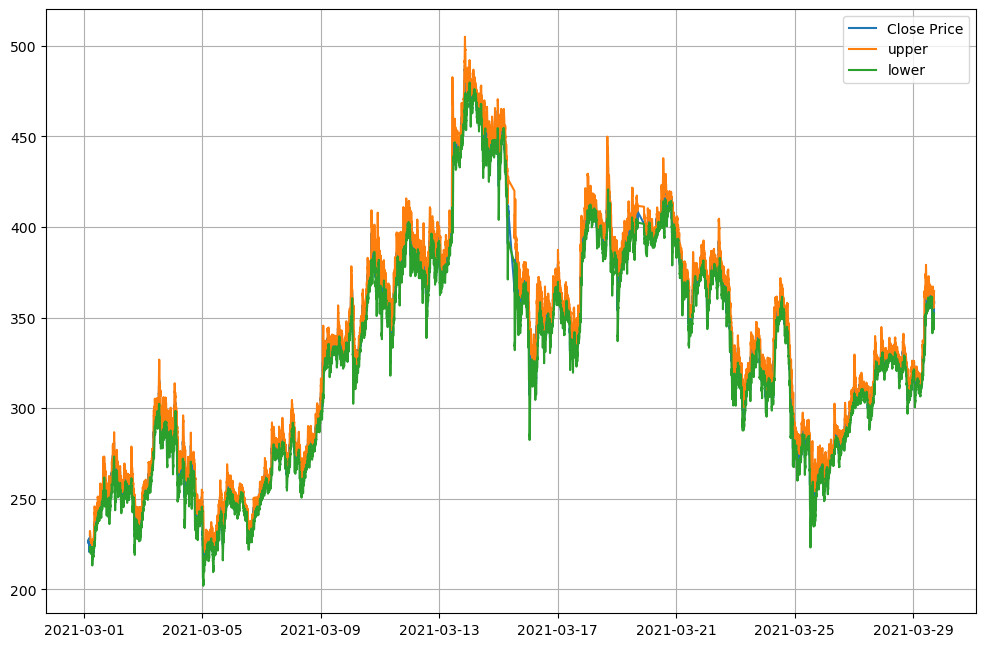

In [25]:
df_1 = df["2021-03-01":]
PERIOD=60
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(df_1['close'],label='Close Price')
plt.plot(df_1['close'].rolling(5).mean()+2*df_1['close'].rolling(PERIOD).std(),label='upper')
plt.plot(df_1['close'].rolling(5).mean()-2*df_1['close'].rolling(PERIOD).std(),label='lower')
plt.grid()
plt.legend()
plt.show()
plt.close()

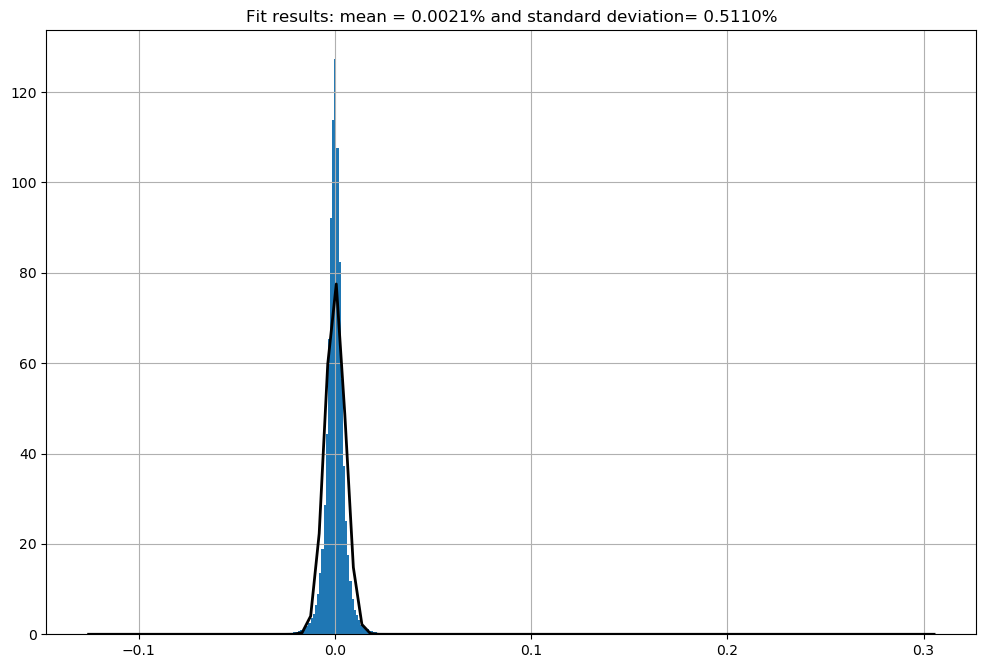

In [26]:
from matplotlib.ticker import PercentFormatter
from scipy.stats import norm
import numpy as np

# Calculate return series
return_series = df[:]['close'].pct_change()
return_series.dropna(inplace=True)

# Create figure
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')

bins = int(np.ceil(np.sqrt(len(return_series))))
plt.hist(return_series,bins=bins, density=True)
plt.grid()


# Plot the PDF.
# Fit a normal distribution to the data:
mu, std = norm.fit(return_series)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mean = %.4f%c and standard deviation= %.4f%c" % (100*mu,'%', 100*std,'%')
plt.title(title)
plt.show()


In [27]:
# start=6385.75
# pp=np.zeros(24*60*365*3)
# pp[0]=start
# for i in range(1,24*60*365*3):
#     new_price=pp[i-1]*(1+norm.rvs()*std+mu)
#     pp[i]=new_price

In [28]:
# plt.plot(pp)

In [31]:
print(df[:]['close'].pct_change().mean())

2.115661264815948e-05


In [23]:
returns = {}
bp = 0.002


def calc_one_return(prices, t_start, bp, actions, t1, t2, total):
    Vi = prices[t_start + t1]; Vf = prices[t_start + t2]
    transaction_cost = abs(actions[t2] - actions[t1])*bp*prices[t_start + t2]
    R = (actions[t1]*(Vf - Vi) - transaction_cost)/(Vi*total)
    return R

def make_return_series(prices, bp, t_start, actions,total):
    num_actions = len(actions)
    R_tot_prev = 0
    R_series = np.empty([num_actions])
    R_single_series = np.empty([num_actions])
    for i in range(num_actions-1):
        R_today = calc_one_return(prices, t_start, bp, actions, i, i+1,total)
        R_tot_new = (1+R_tot_prev)*(1+R_today) - 1
        R_single_series[i]=R_today
        R_series[i] = R_tot_new
        R_tot_prev = R_tot_new
    # just to fill missing values
    R_series[-1] = R_series[-2]
    R_series = np.append(R_series,R_series[-1])
    return R_series, R_single_series

In [30]:
df_1["amount"]

Timestamp
2021-03-01 03:50:00    12.826300
2021-03-01 03:51:00    13.528087
2021-03-01 03:52:00    29.584200
2021-03-01 03:53:00    45.960100
2021-03-01 03:54:00    10.475700
                         ...    
2021-03-29 16:44:00    67.418352
2021-03-29 16:45:00    85.560988
2021-03-29 16:46:00    26.900871
2021-03-29 16:47:00    21.867500
2021-03-29 16:48:00    45.248615
Name: amount, Length: 40365, dtype: float64

In [69]:
t=df["close"].pct_change().rolling(60*24*7).mean()

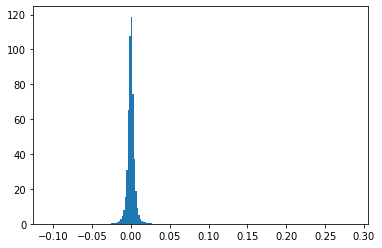

In [79]:
plt.hist(df["close"].pct_change(),200, density=True)
plt.show()

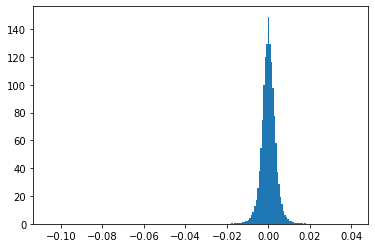

In [80]:
plt.hist(df["2021-03-01":]["close"].pct_change(),200, density=True)
plt.show()

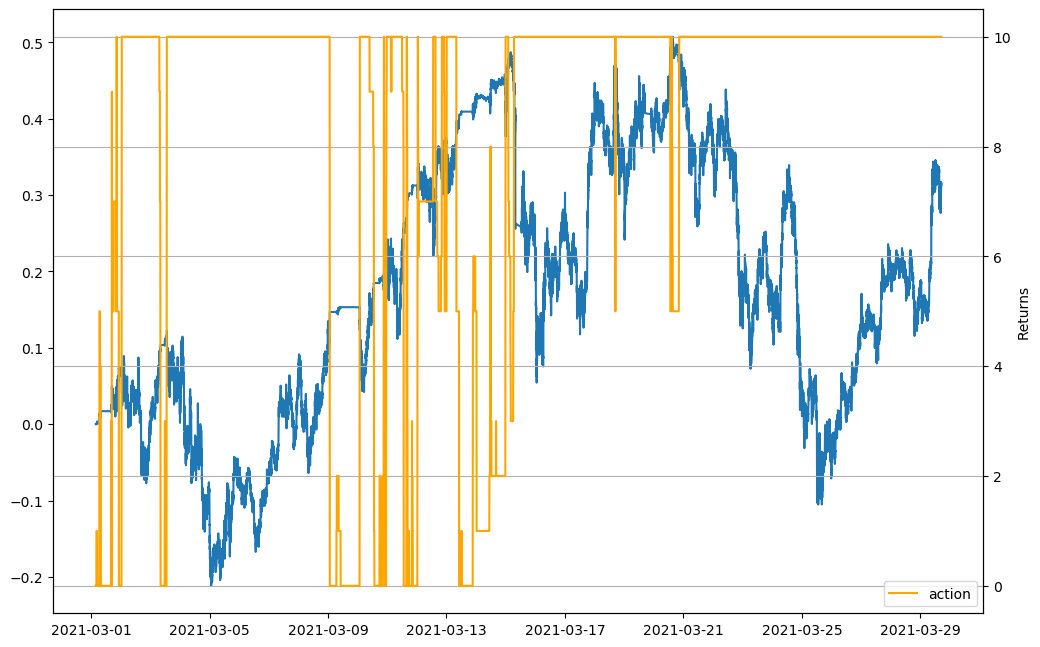

In [97]:
df_1 = df["2021-03-01":]
MAX_HOLDING=10
p=[]
c=[]
k=[]
def get_actions_LongOnly(prices):
    cash=15000
    stock=0
    PERIOD=30
    actions = [0]*(PERIOD-1)
    holding=0
    open_prcie=[]
    # amount = df_1["amount"]
    # amount_mean = df_1["amount"].rolling(PERIOD).mean()
    # prices_max = prices.rolling(PERIOD).max()
    # prices_min = prices.rolling(PERIOD).min()
    prices_mean = prices.rolling(PERIOD).mean()
    # prices_std = prices.rolling(PERIOD).std()
    # prices_percent_std = ((prices-prices.diff())/prices).rolling(PERIOD).std()
    INIT_COLD = 1
    INIT_COLD_SELL = 0
    cold_time = INIT_COLD
    cnt=0
    RETURN_RATE = 1.03
    for i in range(PERIOD,len(prices)):
        if holding and prices[i]>open_prcie[-1]*RETURN_RATE:
            while holding and prices[i]>open_prcie[-1]*RETURN_RATE:
                holding-=1

                cash+=prices[i]
                stock-=1

                open_prcie.pop()
                cnt+=1
                cold_time = INIT_COLD_SELL
            actions.append(holding)            
        elif cold_time==0 and holding<MAX_HOLDING and prices[i]<prices_mean[i-1]*0.98:
            holding +=1
            cold_time = INIT_COLD
            actions.append(holding)
            open_prcie.append(prices[i])
            c.append(prices[i])
            cash-=prices[i]
            stock+=1
        else:
            actions.append(actions[-1])
        p.append(cash+stock*prices[i])
        cold_time=max(cold_time-1,0)
        open_prcie.sort(reverse=True)
    return actions


prices = df_1['close'].copy()
prices.dropna(inplace=True)

actions = get_actions_LongOnly(prices)
long_only_rets,R_single_series = make_return_series(prices,bp,1,actions,MAX_HOLDING)


fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.plot(prices.index.values,long_only_rets,label='Long Only Returns')
ax2 = ax.twinx()
ax2.plot(prices.index.values,[0]+actions,label='action', color='orange')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.grid()
plt.legend()
plt.show()

In [91]:
R_single_series.mean()/R_single_series.std() * (365*24*60)**0.5

3.610141703658022

In [18]:
def show_acc_return(actions, prices):
    cash=15000
    stock=0
    p=[]
    for i,a in enumerate(actions):
        if i>0:
            diff = a-actions[i-1]
            cash-=diff*prices[i+1]
            stock+=diff
            p.append(cash+stock*prices[i+1])
    plt.plot(p)
    plt.close()

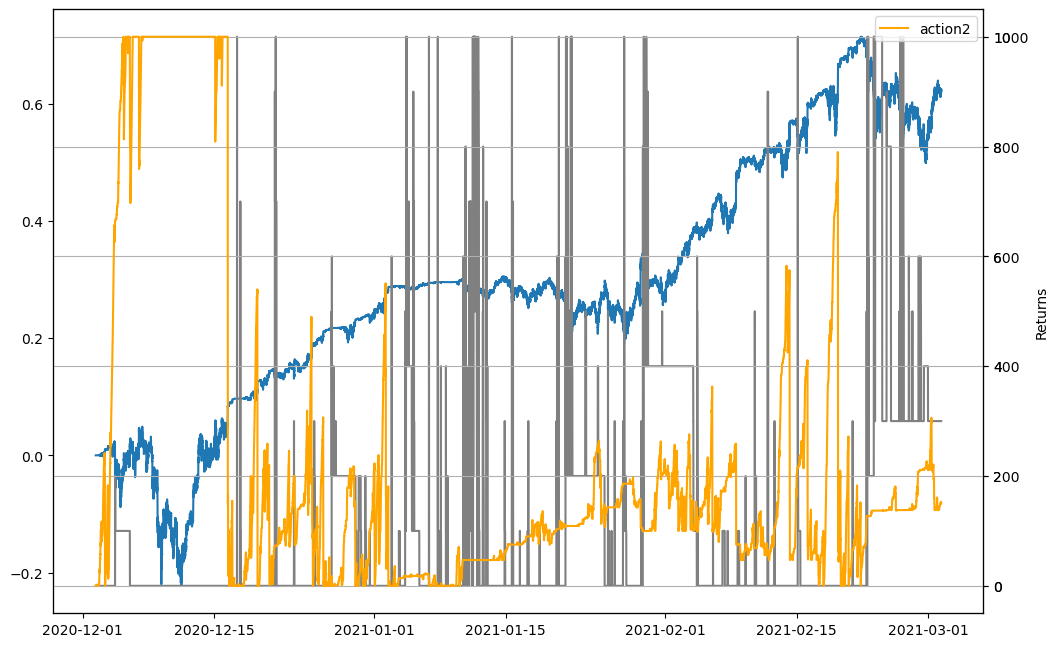

In [64]:
MAX_HOLDING=1000
p=[]
c=[]
k=[]
def get_actions_LongOnly2(prices):
    cash=15000
    stock=0
    PERIOD=10
    actions = [0]*(PERIOD-1)
    holding=0
    open_prcie=[]
    prices_max = prices.rolling(PERIOD).max()
    prices_min = prices.rolling(PERIOD).min()
    prices_mean = prices.rolling(PERIOD).mean()
    prices_std = prices.rolling(PERIOD).std()
    std_mean = prices_std.mean()
    prices_percent_std = (prices.pct_change()).rolling(PERIOD).std()
    percent_std_mean = prices_percent_std.mean()
    INIT_COLD = 0
    INIT_COLD_SELL = 5
    cold_time = INIT_COLD
    cnt=0
    for i in range(PERIOD,len(prices)):
        if holding and prices[i]>open_prcie[-1]*1.03:
            while holding and prices[i]>open_prcie[-1]*1.03:
                holding-=1

                cash+=prices[i]
                stock-=1

                open_prcie.pop()
                cnt+=1
                cold_time = INIT_COLD_SELL
            actions.append(holding)            
        elif cold_time==0 and holding<MAX_HOLDING and prices_percent_std[i-1]<percent_std_mean*0.5:
            holding +=1
            cold_time = INIT_COLD
            actions.append(holding)
            open_prcie.append(prices[i])
            c.append(prices[i])
            cash-=prices[i]
            stock+=1
        else:
            actions.append(actions[-1])
        p.append(cash+stock*prices[i])
        cold_time=max(cold_time-1,0)
        open_prcie.sort(reverse=True)
    return actions


prices = df_1['close'].copy()
prices.dropna(inplace=True)

actions2 = get_actions_LongOnly2(prices)
long_only_rets2,R_single_series2 = make_return_series(prices,bp,1,actions2,MAX_HOLDING)


fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax3 = ax.twinx()
ax3.plot(prices.index.values,[0]+actions,label='action', color='grey')
ax2 = ax.twinx()
ax2.plot(prices.index.values,[0]+actions2,label='action2', color='orange')
ax.plot(prices.index.values,long_only_rets2,label='Long Only Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.grid()
plt.legend()
plt.show()

In [65]:
print(R_single_series2.mean()/R_single_series2.std() * (365*24*60)**0.5)

2.0331774432220056


In [49]:
prices.rolling(30).std().std()

1.8437100559918655

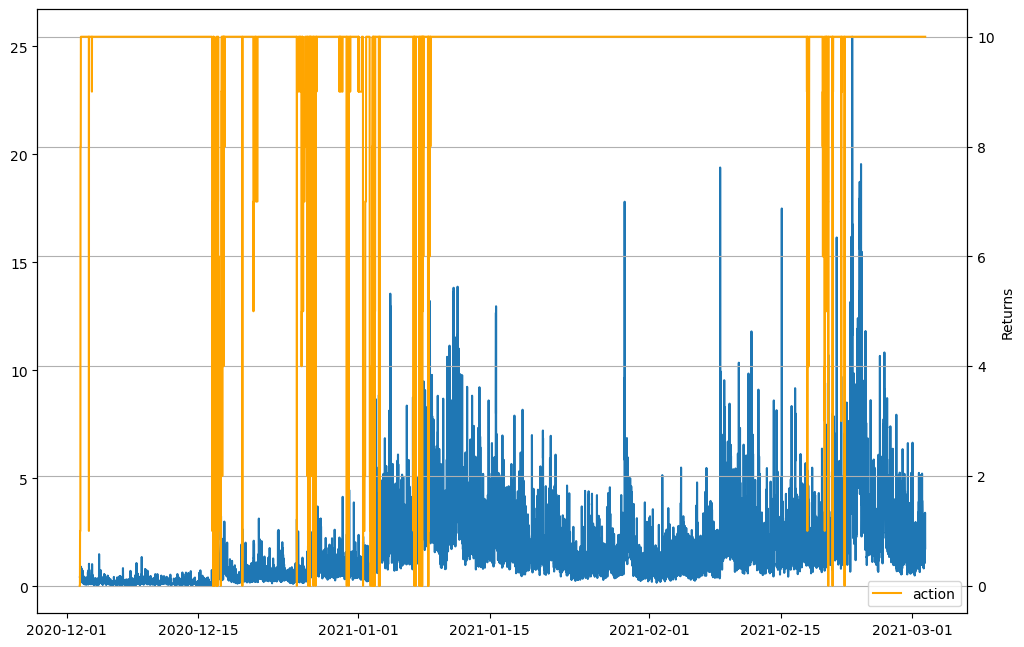

In [47]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.plot(prices.index.values,prices.rolling(30).std(),label='Long Only Returns')
ax2 = ax.twinx()
ax2.plot(prices.index.values,[0]+actions2,label='action', color='orange')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.grid()
plt.legend()
plt.show()

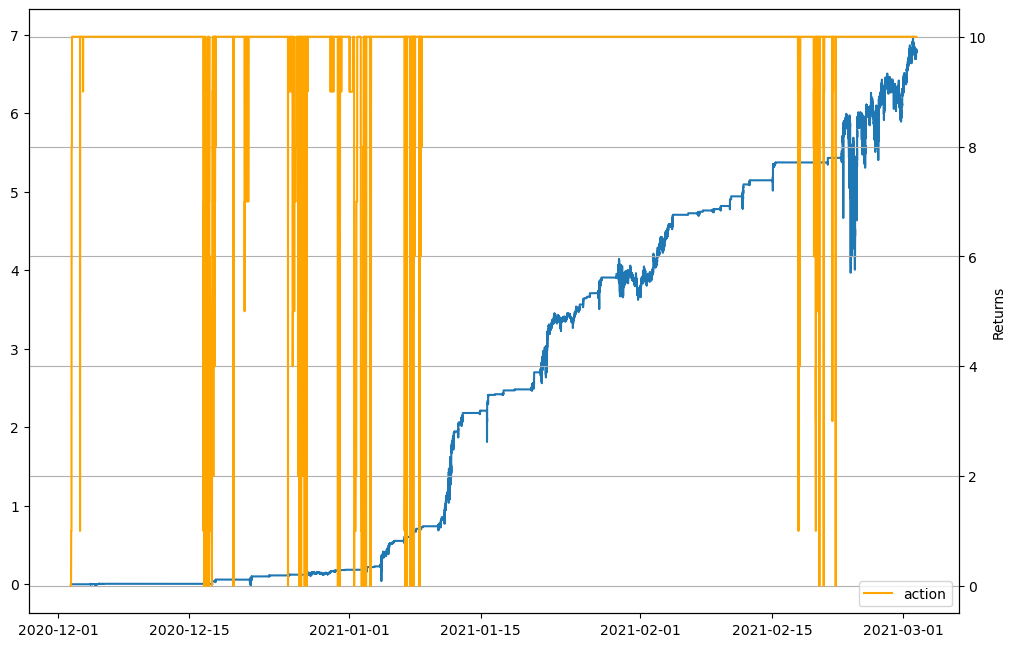

In [45]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.plot(prices.index.values,long_only_rets,label='Long Only Returns')
ax2 = ax.twinx()
ax2.plot(prices.index.values,[0]+actions,label='action', color='orange')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.grid()
plt.legend()
plt.show()

In [89]:
prices.rolling(24*60*30).mean()

Timestamp
2018-07-01 00:00:00            NaN
2018-07-01 00:01:00            NaN
2018-07-01 00:02:00            NaN
2018-07-01 00:03:00            NaN
2018-07-01 00:04:00            NaN
                          ...     
2020-07-01 23:55:00    9450.534815
2020-07-01 23:56:00    9450.527340
2020-07-01 23:57:00    9450.519906
2020-07-01 23:58:00    9450.512443
2020-07-01 23:59:00    9450.505089
Name: Close, Length: 1013977, dtype: float64

In [1]:
USDT=130.25749382
COIN =0.00000149
def target_price(y):
    return (y+USDT)/COIN

In [4]:
x=np.arange(70,78,0.1)
# y=[target_price(i) for i in x]
for i in x:
    print(f"{i:0.3f}", target_price(i))

70.000 1639.82901723013
70.100 1640.647877481474
70.200 1641.4667377328183
70.300 1642.2855979841625
70.400 1643.1044582355066
70.500 1643.9233184868508
70.600 1644.742178738195
70.700 1645.5610389895394
70.800 1646.3798992408836
70.900 1647.1987594922277
71.000 1648.017619743572
71.100 1648.836479994916
71.200 1649.6553402462603
71.300 1650.4742004976044
71.400 1651.2930607489486
71.500 1652.1119210002928
71.600 1652.930781251637
71.700 1653.7496415029811
71.800 1654.5685017543253
71.900 1655.3873620056695
72.000 1656.206222257014
72.100 1657.025082508358
72.200 1657.8439427597023
72.300 1658.6628030110464
72.400 1659.4816632623906
72.500 1660.3005235137348
72.600 1661.119383765079
72.700 1661.9382440164231
72.800 1662.7571042677673
72.900 1663.5759645191115
73.000 1664.3948247704557
73.100 1665.2136850217998
73.200 1666.0325452731443
73.300 1666.8514055244884
73.400 1667.6702657758326
73.500 1668.4891260271768
73.600 1669.307986278521
73.700 1670.1268465298651
73.800 1670.94570678120

In [2]:
def target_priceETH1(y):
    USDT=144.17920744
    COIN =0.12902829 
    return (y+USDT)/COIN
x=np.arange(76,91,0.1)
# y=[target_price(i) for i in x]
for i in x:
    print(f"{i:0.3f}", target_priceETH1(i))

76.000 1706.4413349971546
76.100 1707.216358831075
76.200 1707.9913826649954
76.300 1708.7664064989158
76.400 1709.5414303328362
76.500 1710.3164541667566
76.600 1711.0914780006772
76.700 1711.8665018345976
76.800 1712.641525668518
76.900 1713.4165495024383
77.000 1714.1915733363587
77.100 1714.966597170279
77.200 1715.7416210041995
77.300 1716.5166448381199
77.400 1717.2916686720403
77.500 1718.0666925059606
77.600 1718.8417163398813
77.700 1719.6167401738016
77.800 1720.391764007722
77.900 1721.1667878416424
78.000 1721.9418116755628
78.100 1722.7168355094832
78.200 1723.4918593434036
78.300 1724.266883177324
78.400 1725.0419070112443
78.500 1725.8169308451647
78.600 1726.5919546790853
78.700 1727.3669785130057
78.800 1728.1420023469261
78.900 1728.9170261808465
79.000 1729.692050014767
79.100 1730.4670738486873
79.200 1731.2420976826077
79.300 1732.017121516528
79.400 1732.7921453504484
79.500 1733.5671691843688
79.600 1734.3421930182894
79.700 1735.1172168522098
79.800 1735.8922406

In [1]:
import numpy as np

In [3]:
# short
USDT=0.07288896
COIN =0.00000149
def target_price2(y):
    return (USDT-y)/COIN

In [4]:
x=np.arange(0.015,0.020,0.0001)
# y=[target_price(i) for i in x]
for i in x:
    print(f"{i:0.5f}", target_price2(i))

0.01500 38851.651006711414
0.01510 38784.53691275168
0.01520 38717.42281879195
0.01530 38650.30872483222
0.01540 38583.19463087249
0.01550 38516.080536912756
0.01560 38448.966442953024
0.01570 38381.8523489933
0.01580 38314.73825503357
0.01590 38247.62416107383
0.01600 38180.510067114104
0.01610 38113.39597315437
0.01620 38046.28187919464
0.01630 37979.16778523491
0.01640 37912.05369127518
0.01650 37844.939597315446
0.01660 37777.825503355714
0.01670 37710.71140939598
0.01680 37643.59731543625
0.01690 37576.48322147653
0.01700 37509.36912751679
0.01710 37442.255033557056
0.01720 37375.14093959733
0.01730 37308.0268456376
0.01740 37240.91275167787
0.01750 37173.79865771813
0.01760 37106.684563758405
0.01770 37039.57046979867
0.01780 36972.45637583894
0.01790 36905.34228187921
0.01800 36838.22818791948
0.01810 36771.11409395975
0.01820 36704.000000000015
0.01830 36636.88590604028
0.01840 36569.77181208055
0.01850 36502.65771812083
0.01860 36435.543624161095
0.01870 36368.429530201356
0.0

In [15]:
# short
def target_priceETH(y):
    COIN=0.00002105
    USDT=0.04439485 
    return (USDT-y)/COIN
x=np.arange(0.007,0.009,0.00001)
# y=[target_price(i) for i in x]
for i in x:
    print(f"{i:0.5f}", target_priceETH(i))

0.00700 1776.477434679335
0.00701 1776.002375296912
0.00702 1775.5273159144895
0.00703 1775.0522565320664
0.00704 1774.5771971496438
0.00705 1774.102137767221
0.00706 1773.6270783847983
0.00707 1773.1520190023753
0.00708 1772.6769596199526
0.00709 1772.2019002375298
0.00710 1771.7268408551072
0.00711 1771.2517814726841
0.00712 1770.7767220902615
0.00713 1770.3016627078387
0.00714 1769.826603325416
0.00715 1769.351543942993
0.00716 1768.8764845605704
0.00717 1768.4014251781475
0.00718 1767.926365795725
0.00719 1767.4513064133018
0.00720 1766.9762470308792
0.00721 1766.5011876484564
0.00722 1766.0261282660338
0.00723 1765.5510688836107
0.00724 1765.076009501188
0.00725 1764.6009501187652
0.00726 1764.1258907363426
0.00727 1763.6508313539196
0.00728 1763.175771971497
0.00729 1762.700712589074
0.00730 1762.2256532066515
0.00731 1761.7505938242284
0.00732 1761.2755344418058
0.00733 1760.800475059383
0.00734 1760.3254156769603
0.00735 1759.8503562945373
0.00736 1759.3752969121147
0.00737 175

In [130]:
data=pd.Series(np.array(df['close'].dropna()))

In [131]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(np.asarray(data),order=(1,2,1)) # ARIMA = (2,1,2)

In [132]:
t=model.fit()

In [133]:
print(t.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2871
Model:                 ARIMA(1, 2, 1)   Log Likelihood              -15093.961
Date:                Sun, 21 Feb 2021   AIC                          30193.922
Time:                        21:35:50   BIC                          30211.807
Sample:                             0   HQIC                         30200.370
                               - 2871                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0597      0.016     -3.762      0.000      -0.091      -0.029
ma.L1         -0.9998      0.008   -131.114      0.000      -1.015      -0.985
sigma2      2162.2887     41.450     52.167      0.0

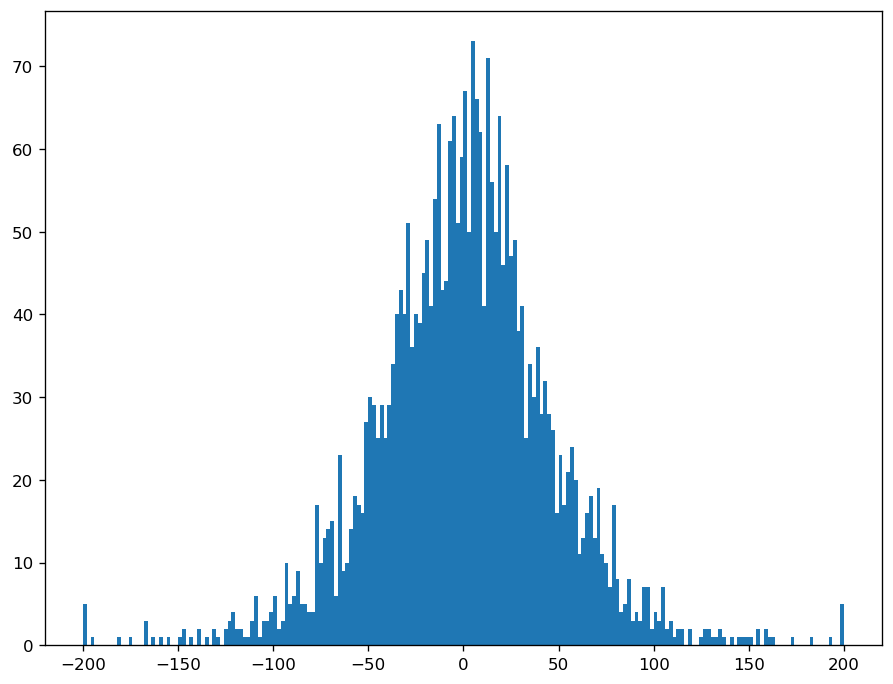

In [134]:
residuals = pd.DataFrame(t.resid, columns=['residuals'])
plt.hist(residuals.clip(-200,200), 200)
plt.show()
plt.close()

In [135]:
preds = t.predict(1, 30000, typ='levels')

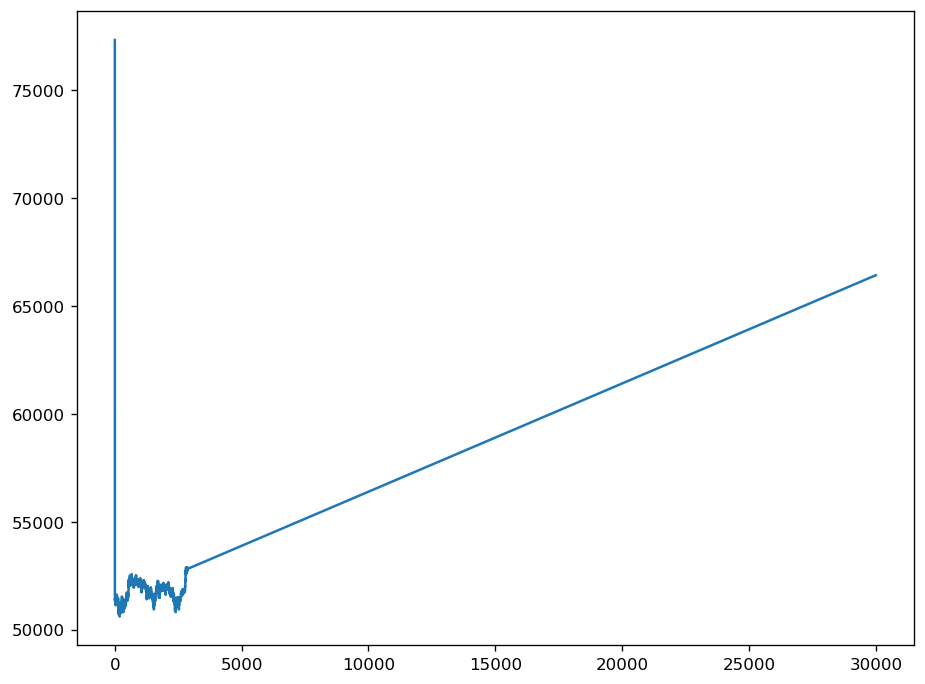

In [136]:
plt.plot(preds)

In [85]:
from pmdarima.arima.utils import ndiffs
## Adf Test
ndiffs(data, test='adf')  # 2

1